In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [2]:
import os

## download imdb dataset

In [3]:
path = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
keras.utils.get_file(fname='imdb',origin=path, untar=True)

'/root/.keras/datasets/imdb'

In [4]:
!pwd

/content


# EDA

In [5]:
f=open('/root/.keras/datasets/aclImdb/test/neg/10001_1.txt','r')
print(f.read())
f.close()

First of all I hate those moronic rappers, who could'nt act if they had a gun pressed against their foreheads. All they do is curse and shoot each other and acting like cliché'e version of gangsters.<br /><br />The movie doesn't take more than five minutes to explain what is going on before we're already at the warehouse There is not a single sympathetic character in this movie, except for the homeless guy, who is also the only one with half a brain.<br /><br />Bill Paxton and William Sadler are both hill billies and Sadlers character is just as much a villain as the gangsters. I did'nt like him right from the start.<br /><br />The movie is filled with pointless violence and Walter Hills specialty: people falling through windows with glass flying everywhere. There is pretty much no plot and it is a big problem when you root for no-one. Everybody dies, except from Paxton and the homeless guy and everybody get what they deserve.<br /><br />The only two black people that can act is the ho

# generating train and test data

In [6]:
%cd /root/.keras/datasets/aclImdb/train/
x_train = []
y_train =[]
root_path = '/root/.keras/datasets/aclImdb/train/'
for y_label in ['neg','pos']:
  path=os.path.join(root_path,y_label)
  for file_name in list(os.listdir(path)):
    if file_name[-4:]=='.txt':
      f=open(os.path.join(path,file_name), encoding="utf8")
      x_train.append(f.read())
      f.close()
      if y_label =='neg':
        y_train.append(0)
      else:
        y_train.append(1)
        

/root/.keras/datasets/aclImdb/train


In [7]:
print(np.shape(x_train))
print(y_train[-1])
print(x_train[1])

(25000,)
1
I have walked out of very few movies before they end, but I couldn't finish this piece of garbage. This was the biggest load of racism trying to pass as legitimate film since "Birth of a Nation". The characters were little more than cardboard cutouts. I don't see how any actor would want their name associated with this film. Lee must have better things to do that put out garbage like this. I know that I and anyone with a brain have better things to do.... like watching paint dry. I wish that someone would make a film about interracial relationships that dealt with the topic realistically. There is a lot more depth to this subject the shallow ranting of a bitter director like Lee.


In [8]:
%cd /root/.keras/datasets/aclImdb/test/
x_test = []
y_test =[]
root_path = '/root/.keras/datasets/aclImdb/test/'
for y_label in ['neg','pos']:
  path=os.path.join(root_path,y_label)
  for file_name in list(os.listdir(path)):
    if file_name[-4:]=='.txt':
      f=open(os.path.join(path,file_name), encoding="utf8")
      x_test.append(f.read())
      f.close()
      if y_label =='neg':
        y_test.append(0)
      else:
        y_test.append(1)
        

/root/.keras/datasets/aclImdb/test


In [9]:
print(np.shape(x_test))
print(y_test[1])
print(x_test[1])

(25000,)
0
The EMPEROR'S NEW GROOVE cast returns for Disney Pictures follow up, but this time the spotlight is on Kronk(voiced by Patrick Warburton), who is no longer Yzma's(Eartha Kitt)henchman. Kronk has started a new life and is very happy with his role as chef of his own restaurant. Things go merrily along until Kronk gets word that his Papi(John Mahoney)is coming for a visit. Kronk is worried, because he knows that his life won't impress his Papi. One thing that he has always wanted and never received is a "thumbs up" from his dad. A flurry of blunders and a gigantic cheese explosion in the restaurant leaves our likable hero very deep in trouble and anxiety. To save the day, a little help from his friends.<br /><br />Other voices: Tracey Ullman, David Spade, John Goodman, Wendie Malick, April Winchell and Gatlin Green.


# preproccessing text data

In [10]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences 
maxlen = 100  # We will cut reviews after 100 words
training_samples =20000
validation_samples = 1000 
max_words = 10000  # We will only consider the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train)
sequences = tokenizer.texts_to_sequences(x_train)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 88582 unique tokens.


In [11]:
x_train = pad_sequences(sequences, maxlen=maxlen)
y_train = np.asarray(y_train)

print('Shape of data tensor:', x_train.shape)
print('Shape of label tensor:', y_train.shape)

indices = np.arange(x_train.shape[0])
np.random.shuffle(indices)

data = x_train[indices]
label = y_train[indices]



Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [12]:
x_train = data[:training_samples]
y_train = label[:training_samples]
print('Shape of data tensor:', x_train.shape)

Shape of data tensor: (20000, 100)


In [13]:
x_val = data[training_samples: training_samples + validation_samples]
y_val = label[training_samples: training_samples + validation_samples]
print('Shape of data tensor:', x_val.shape)

Shape of data tensor: (1000, 100)


# download pre_trained word embedding

In [14]:
embd_path = 'https://nlp.stanford.edu/data/glove.6B.zip'
embd = keras.utils.get_file(fname='glove',origin=embd_path,cache_subdir='embd',untar=True)

In [15]:
%cd /root/.keras/embd

/root/.keras/embd


In [16]:
!unzip glove.tar.gz

Archive:  glove.tar.gz
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace glove.6B.100d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace glove.6B.200d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace glove.6B.300d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


# generate embedding matrix

In [17]:
embeddings_index = {}
f = open(os.path.join('/root/.keras/embd/','glove.6B.50d.txt'),encoding="utf8")
for line in f:
      values = line.split()
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))


Found 400000 word vectors.


In [18]:
embedding_dim = 50
max_words =10000
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

In [19]:
# sequences[1]
# word_index
x_train.shape

(20000, 100)

# creat model

In [20]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           500000    
                                                                 
 flatten (Flatten)           (None, 5000)              0         
                                                                 
 dense (Dense)               (None, 32)                160032    
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 660,065
Trainable params: 660,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 8s 12ms/step - loss: 0.4443 - acc: 0.7828 - val_loss: 0.3689 - val_acc: 0.8280
Epoch 2/10
625/625 [=============================

In [21]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [22]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')


Epoch 1/10
625/625 [==============================] - 3s 5ms/step - loss: 1.0021 - acc: 0.4996 - val_loss: 0.6934 - val_acc: 0.4860
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 0.6936 - acc: 0.5009 - val_loss: 0.6934 - val_acc: 0.5140
Epoch 3/10
625/625 [==============================] - 7s 11ms/step - loss: 0.6935 - acc: 0.4978 - val_loss: 0.6938 - val_acc: 0.4860
Epoch 4/10
625/625 [==============================] - 7s 11ms/step - loss: 0.6917 - acc: 0.5042 - val_loss: 0.6947 - val_acc: 0.4870
Epoch 5/10
625/625 [==============================] - 7s 11ms/step - loss: 0.6910 - acc: 0.4991 - val_loss: 0.7101 - val_acc: 0.4890
Epoch 6/10
625/625 [==============================] - 7s 11ms/step - loss: 0.6840 - acc: 0.5418 - val_loss: 0.7047 - val_acc: 0.5670
Epoch 7/10
625/625 [==============================] - 7s 11ms/step - loss: 0.6538 - acc: 0.5982 - val_loss: 0.6859 - val_acc: 0.5700
Epoch 8/10
625/625 [==============================] - 7s 11ms/step - lo

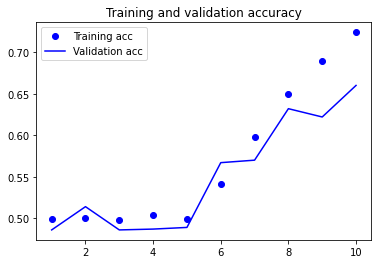

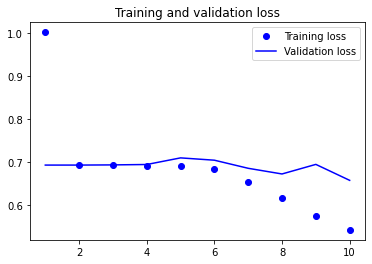

In [23]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# evaluate on test set

In [24]:
sequences = tokenizer.texts_to_sequences(x_test)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(y_test)

In [25]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

782/782 [==============================] - 2s 2ms/step - loss: 0.6496 - acc: 0.6652


[0.6495718955993652, 0.6652399897575378]